<a href="https://colab.research.google.com/github/tudao1/Doan_project_yolov8_vehicle/blob/main/speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Install

In [ ]:
!pip install -q supervision ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 38.1 MB/s eta 0:00:00


In [ ]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

**NOTE:** In this notebook we will use one of the Supervision Assets videos. [Here](https://supervision.roboflow.com/assets) you can learn more about it.

In [ ]:
download_assets(VideoAssets.VEHICLES)

  0%|          | 0/35345757 [00:00<?, ?it/s]

'vehicles.mp4'

## Configuration

In [ ]:
SOURCE_VIDEO_PATH = "vehicles.mp4"
TARGET_VIDEO_PATH = "vehicles-result.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1280

## Source and Target ROIs

![Source and Target ROIs](https://storage.googleapis.com/com-roboflow-marketing/notebooks/speed-estimation-perspective-1.png)

In [ ]:
SOURCE = np.array([
    [1252, 787],
    [2298, 803],
    [5039, 2159],
    [-550, 2159]
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 250

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

In [ ]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.


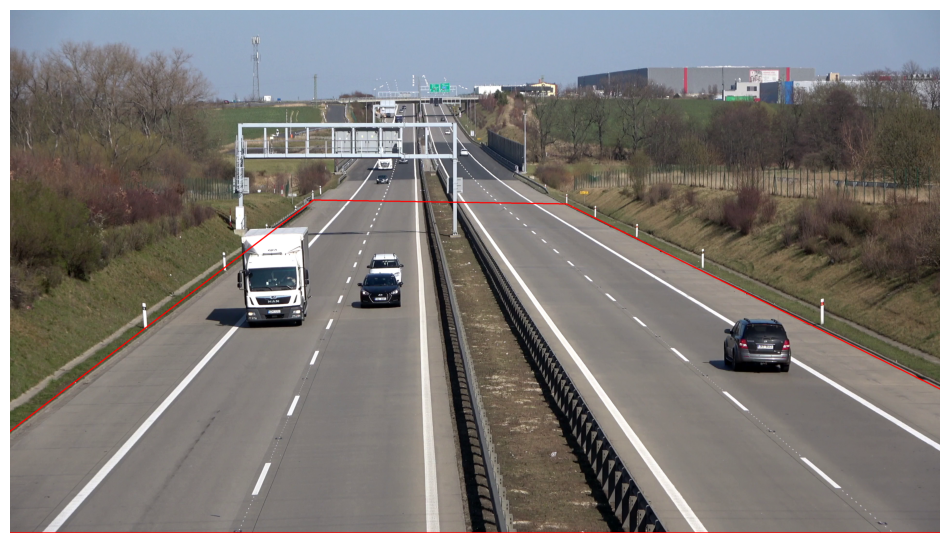

In [ ]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.red(), thickness=4)
sv.plot_image(annotated_frame)

## Transform Perspective

In [ ]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [ ]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

In [ ]:
!pip install supervision

## Process Video

**NOTE:** In this tutorial we use Supervision Annotators. [Here](https://supervision.roboflow.com/annotators) you can learn more about it.

In [ ]:
from collections import defaultdict, deque
import supervision as sv
from ultralytics import YOLO
from tqdm import tqdm

# Initialize model
model = YOLO(MODEL_NAME)

# Get video info
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# Initialize tracker with updated parameter
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_activation_threshold=CONFIDENCE_THRESHOLD
)

# Set static values for annotators
thickness = max(1, min(video_info.resolution_wh) // 1000)
text_scale = max(0.5, min(video_info.resolution_wh) / 1000)
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

# Define polygon zone
polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

# Initialize coordinates storage
coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# Open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    # Loop over source video frames
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # Filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # Filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # Refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # Pass detections through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        # Calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # Store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # Format labels
        labels = []
        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"#{tracker_id}")
            else:
                # Calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                labels.append(f"#{tracker_id} {int(speed)} km/h")

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = bounding_box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

        # Add frame to target video
        sink.write_frame(annotated_frame)


100%|██████████| 131M/131M [00:00<00:00, 163MB/s]
SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.
100%|██████████| 538/538 [1:43:57<00:00, 11.59s/it]


In [ ]:
from collections import defaultdict, deque
import supervision as sv
from ultralytics import YOLO
from tqdm import tqdm

# Initialize model
model = YOLO(MODEL_NAME)

# Get video info
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# Initialize tracker with updated parameter
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_activation_threshold=CONFIDENCE_THRESHOLD
)

# Set static values for annotators
thickness = max(1, min(video_info.resolution_wh) // 1000)
text_scale = max(0.5, min(video_info.resolution_wh) / 1000)
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

# Define polygon zone
polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

# Initialize coordinates storage
coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# Open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    # Loop over source video frames
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # Filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # Filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # Refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # Pass detections through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        # Calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # Store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # Format labels
        labels = []
        for (x, y), tracker_id in zip(points, detections.tracker_id):
            label = f"x: {x}, y: {y}"
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                label += f" #{tracker_id}"
            else:
                # Calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                label += f" #{tracker_id} {int(speed)} km/h"
            labels.append(label)

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = bounding_box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

        # Add frame to target video
        sink.write_frame(annotated_frame)


SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.
100%|██████████| 538/538 [02:14<00:00,  3.99it/s]


In [ ]:
import cv2

# Đường dẫn tới video
video_path = '/content/vehicles.mp4'

# Mở video bằng OpenCV
video_capture = cv2.VideoCapture(video_path)

# Kiểm tra nếu video mở thành công
if not video_capture.isOpened():
    print("Error: Không thể mở video.")
else:
    # Lấy FPS của video
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    print(f"Số FPS của video là: {fps}")

# Giải phóng đối tượng video
video_capture.release()


Số FPS của video là: 25.0


In [ ]:
download_assets(VideoAssets.VEHICLES_2)

  0%|          | 0/29782444 [00:00<?, ?it/s]

'vehicles-2.mp4'

In [ ]:
import cv2

# Đường dẫn tới video
video_path = '/content/vehicles-2.mp4'

# Mở video bằng OpenCV
video_capture = cv2.VideoCapture(video_path)

# Kiểm tra nếu video mở thành công
if not video_capture.isOpened():
    print("Error: Không thể mở video.")
else:
    # Lấy FPS của video
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    print(f"Số FPS của video là: {fps}")

# Giải phóng đối tượng video
video_capture.release()


Số FPS của video là: 29.97002997002997


In [ ]:
SOURCE_VIDEO_PATH = "vehicles-2.mp4"
TARGET_VIDEO_PATH = "vehicles-result1.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1280

In [ ]:
# extract video frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)

frame = next(iterator)

# save first frame
cv2.imwrite("first_frame.png", frame)

True

In [ ]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

In [ ]:
SOURCE = np.array([
    [150, 956],[638, 644],[1314, 628],[1854, 980],[1854, 980]
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 250

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

In [ ]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.


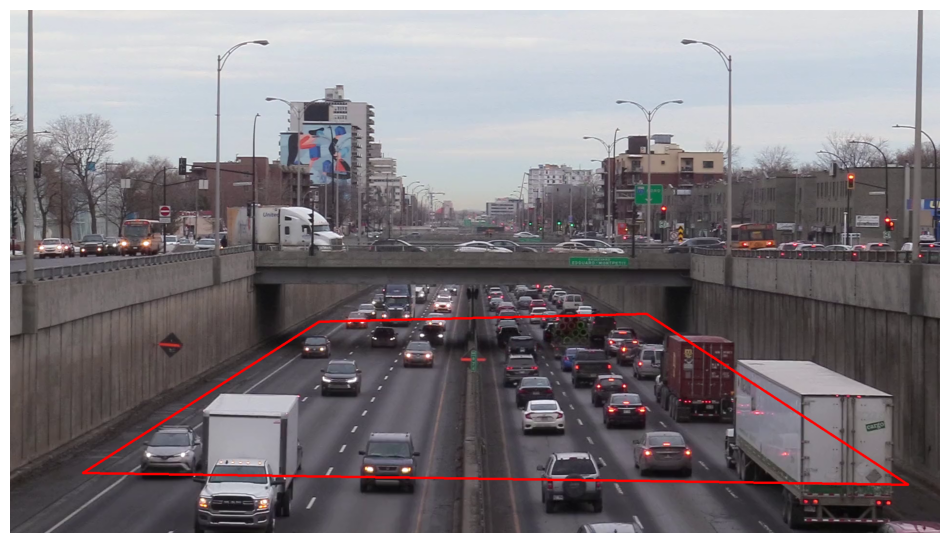

In [ ]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.red(), thickness=4)
sv.plot_image(annotated_frame)

In [ ]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [ ]:
SOURCE = SOURCE[:4]
TARGET = TARGET[:4]

view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

In [ ]:
from collections import defaultdict, deque
import supervision as sv
from ultralytics import YOLO
from tqdm import tqdm

# Initialize model
model = YOLO(MODEL_NAME)

# Get video info
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# Initialize tracker with updated parameter
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_activation_threshold=CONFIDENCE_THRESHOLD
)

# Set static values for annotators
thickness = max(1, min(video_info.resolution_wh) // 1000) # tinh cac duong truy vet cua doi tuong
text_scale = max(0.5, min(video_info.resolution_wh) / 1000)
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
#ve cac duong truy vet cua doi tuong
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

# Define polygon zone
polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

# Initialize coordinates storage
coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# Open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    # Loop over source video frames
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # Filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # Filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # Refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # Pass detections through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        # Calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # Store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # Format labels
        labels = []
        for (x, y), tracker_id in zip(points, detections.tracker_id):
            label = f"x: {x}, y: {y}"
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                label += f" #{tracker_id}"
            else:
                # Calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                label += f" #{tracker_id} {int(speed)} km/h"
            labels.append(label)

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = bounding_box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

        # Add frame to target video
        sink.write_frame(annotated_frame)


SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.
100%|██████████| 1275/1275 [03:46<00:00,  5.64it/s]


In [ ]:
print(model.model.names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw